In [1]:
from __future__ import print_function, division

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = (10,6)
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(context="poster", style="ticks")
import ipywidgets
import yt

import glob
import os
import warnings
import h5py

import numpy as np
import pandas as pd

from units import M_solar, m_proton, pc, yr, Myr, km, s, gamma

from injection_helpers import get_SNe

from visualize_helpers import \
    get_snapshot_filenames, \
    snapshot_filename_to_number, \
    total_mass_of_snapshot, \
    total_radial_momentum_of_snapshot, \
    map_to_all_snapshots, \
    get_snapshot_times, \
    total_kinetic_energy_of_snapshot, \
    total_internal_energy_of_snapshot, \
    load_snapshots, \
    plot_projected_density, \
    plot_sliced_field, \
    plot_phase_diagram, \
    field_type, \
    plot_profile, \
    yt_plot_saver, \
    mpl_plot_saver, \
    load_ds_from_ts

import MHD
    
from sql_helpers import add_simulation, \
    open_as_DataFrame

%load_ext autoreload
%autoreload 2

`grackle_helpers.wrapped_initializer` is setting up grackle assuming code units:
    mass   : 1.0 M_solar
    length : 1.0 pc
    time   : 1.0 Myr

grackle cooling file:  b'/pfs/home/egentry/local/grackle/input/CloudyData_UVB=HM2012.h5'
`grackle_helpers.wrapped_initializer` is setting up grackle assuming code units:
    mass   : 8.41e-58 M_solar
    length : 3.24e-19 pc
    time   : 3.17e-14 Myr

grackle cooling file:  b'/pfs/home/egentry/local/grackle/input/CloudyData_UVB=HM2012.h5'


In [2]:
# run_name = "cluster"
# run_name = "cluster_cooling"
# run_name = "cluster_cooling_100"
# run_name = "cluster_cooling_150"
# run_name = "cluster_cooling_200"
# run_name = "cluster_cooling_mhd_200"
# run_name = "cluster_cooling_mhd_small_200"
run_name = "cluster_cooling_mhd_large_200"
# run_name = "cluster_cooling_250"
# run_name = "cluster_cooling_300"
# run_name = "cluster_cooling_400"
# run_name = "cluster_cooling_small_300"
# run_name = "cluster_cooling_600"
# run_name = "single"
# run_name = "single_cooling"
# run_name = "double"
# run_name = "double_cooling"

run_dir = os.path.join(os.path.pardir, "runs", run_name)

inputs_dir  = os.path.join(run_dir, "inputs")
outputs_dir = os.path.join(run_dir, "outputs")

plots_dir = os.path.join(outputs_dir, "plots")
if not os.path.exists(plots_dir):
    print("making plots_dir")
    os.mkdir(plots_dir)

In [3]:
run_names = [
    "cluster_cooling_100",
    "cluster_cooling_200",
    "cluster_cooling_400",
    "cluster_cooling_mhd_large_200"
]

In [4]:
title_map = {
    "1D" : "1D_06_HD",
    "cluster_cooling_400" :  "3D_10_HD",
    "cluster_cooling_200" :  "3D_20_HD",
    "cluster_cooling_100" :  "3D_40_HD",
    "cluster_cooling_mhd_large_200" :  "3D_20_MHD",
}

In [5]:
dfs = [None]*len(run_names)
for i, run_name in enumerate(run_names):
    add_simulation(run_name, verbose=False)

    df = open_as_DataFrame(run_name)
    
    dfs[i] = df

In [6]:
dfs[0].head()

,number,time,e_kin,e_int,e_mag,mass,momentum,run_name
0,0,0.000000,0.000000e+00,4.938177e+50,0.0,7.097382e+06,0.000000e+00,cluster_cooling_100
1,1,0.001000,0.000000e+00,1.493504e+51,0.0,7.097388e+06,0.000000e+00,cluster_cooling_100
2,2,0.127017,1.325320e+50,7.424824e+50,0.0,7.097388e+06,4.048907e+43,cluster_cooling_100
3,3,0.253034,8.578443e+49,6.853737e+50,0.0,7.097388e+06,4.463213e+43,cluster_cooling_100
4,4,0.379051,6.696951e+49,6.545448e+50,0.0,7.097388e+06,4.669316e+43,cluster_cooling_100


In [7]:
SNe = get_SNe(inputs_dir)
SN_times           = np.array([SN.time          for SN in SNe])
SN_ejecta_masses   = np.array([SN.ejecta_mass   for SN in SNe])
SN_ejecta_masses_Z = np.array([SN.ejecta_mass_Z for SN in SNe])

In [8]:
dfs_energy = [None]*len(dfs)

for i, run_name in enumerate(run_names):
    outputs_dir = "../runs/{}/outputs".format(run_name)
    energies = np.loadtxt(os.path.join(outputs_dir, "energy.txt"), ndmin=2)
    
    times_statistics    = energies[:,0] * Myr
    thermal_energies    = energies[:,1] * M_solar * (pc/Myr)**2
    potential_energies  = energies[:,2] * M_solar * (pc/Myr)**2
    kinetic_energies    = energies[:,3] * M_solar * (pc/Myr)**2

    times_statistics    = times_statistics / Myr
    thermal_energies    = thermal_energies
    potential_energies  = potential_energies
    kinetic_energies    = kinetic_energies
    
    df_energy_tmp = pd.DataFrame(data={
        "time"  : times_statistics,
        "E_int" : thermal_energies,
        "E_kin" : kinetic_energies,
        "E_tot" : thermal_energies + kinetic_energies,
        
    })
    
    df_energy_tmp = df_energy_tmp[["time", "E_int", "E_kin", "E_tot"]]

    
    dfs_energy[i] = df_energy_tmp


In [9]:
dfs_energy[0].head()

,time,E_int,E_kin,E_tot
0,0.000000,4.938177e+50,0.000000e+00,4.938177e+50
1,0.001000,1.493504e+51,0.000000e+00,1.493504e+51
2,0.001000,1.493505e+51,0.000000e+00,1.493505e+51
3,0.011153,1.244959e+51,2.218132e+50,1.466773e+51
4,0.021306,1.130093e+51,2.245737e+50,1.354666e+51


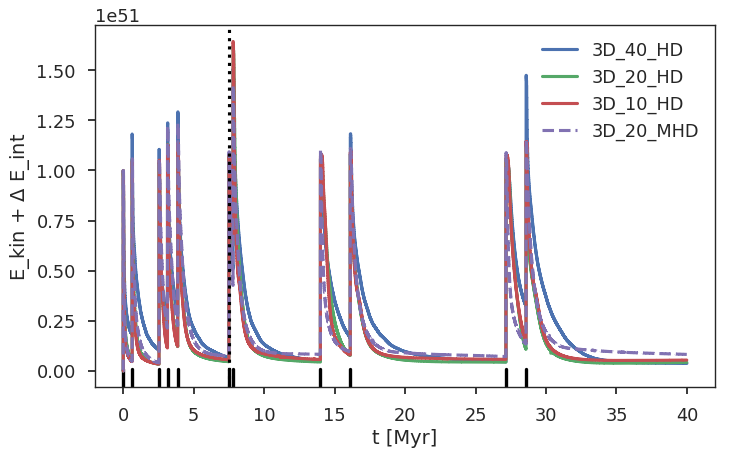

In [10]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]

    linestyle="solid"
    if "mhd" in run_names[i].lower():
        linestyle="dashed"
    
    plt.plot(df_energy.time, E_tot , label=title_map[run_names[i]],
             drawstyle="steps-mid", linestyle=linestyle)

plt.xlabel("t [Myr]")
plt.ylabel("E_kin + $\Delta$ E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
# plt.xlim(10,15)

In [43]:
np.concatenate([[0], df.time.values[1:]])

array([  0.00000000e+00,   1.00000000e-03,   1.27017091e-01,
         2.53034182e-01,   3.79051274e-01,   5.05068364e-01,
         6.31085456e-01,   6.33085456e-01,   1.01489893e+00,
         1.39671241e+00,   1.77852588e+00,   2.16033936e+00,
         2.54215284e+00,   2.54415284e+00,   2.66384118e+00,
         2.78352953e+00,   2.90321788e+00,   3.02290622e+00,
         3.14259457e+00,   3.14459457e+00,   3.28913145e+00,
         3.43366832e+00,   3.57820520e+00,   3.72274208e+00,
         3.86727896e+00,   3.86727896e+00,   3.86927896e+00,
         4.38762538e+00,   4.90597181e+00,   5.42431824e+00,
         5.94266467e+00,   6.46101109e+00,   6.97935752e+00,
         7.49770395e+00,   7.49770396e+00,   7.49970396e+00,
         7.55886489e+00,   7.61802582e+00,   7.67718675e+00,
         7.73634768e+00,   7.79550861e+00,   7.79550861e+00,
         7.79750861e+00,   8.31369008e+00,   8.82987157e+00,
         9.34605305e+00,   9.86223453e+00,   1.03784160e+01,
         1.08945975e+01,

In [51]:
dt = (df.time.values[1:] - df.time.values[:-1])

usable_times = np.concatenate([[True], dt > .002])

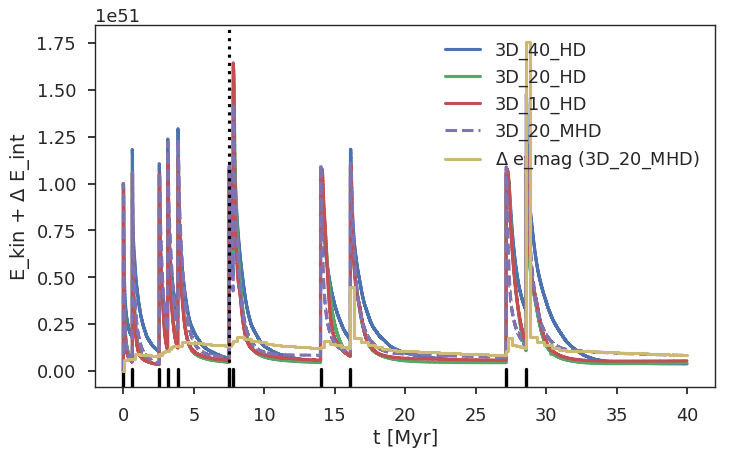

In [53]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]

    linestyle="solid"
    if "mhd" in run_names[i].lower():
        linestyle="dashed"
    
    plt.plot(df_energy.time, E_tot , label=title_map[run_names[i]],
             drawstyle="steps-mid", linestyle=linestyle)
    
df = dfs[-1]
plt.plot(df.time, df.e_mag - df.e_mag.loc[0],
         drawstyle="steps-mid", label = "$\Delta$ e_mag (3D_20_MHD)")

plt.xlabel("t [Myr]")
plt.ylabel("E_kin + $\Delta$ E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
# plt.xlim(10,15)

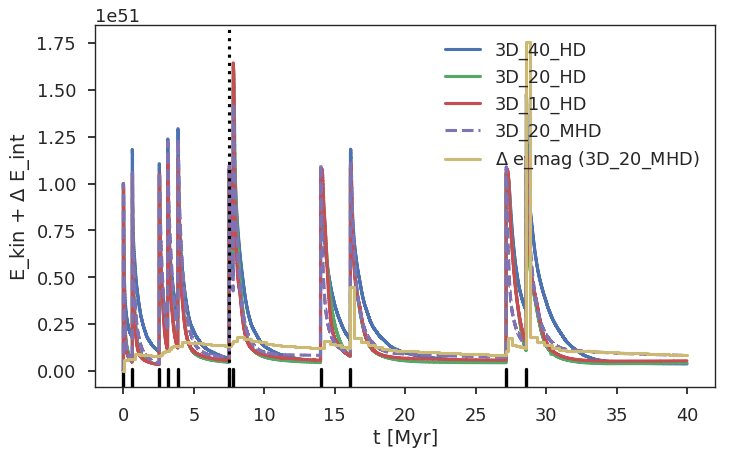

In [52]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]

    linestyle="solid"
    if "mhd" in run_names[i].lower():
        linestyle="dashed"
    
    plt.plot(df_energy.time, E_tot , label=title_map[run_names[i]],
             drawstyle="steps-mid", linestyle=linestyle)
    
df = dfs[-1]
plt.plot(df.time[usable_times], df.e_mag[usable_times] - df.e_mag.loc[0],
         drawstyle="steps-mid", label = "$\Delta$ e_mag (3D_20_MHD)")

plt.xlabel("t [Myr]")
plt.ylabel("E_kin + $\Delta$ E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
# plt.xlim(10,15)

(-6.0043985675265733e+49, 1.6e+51)

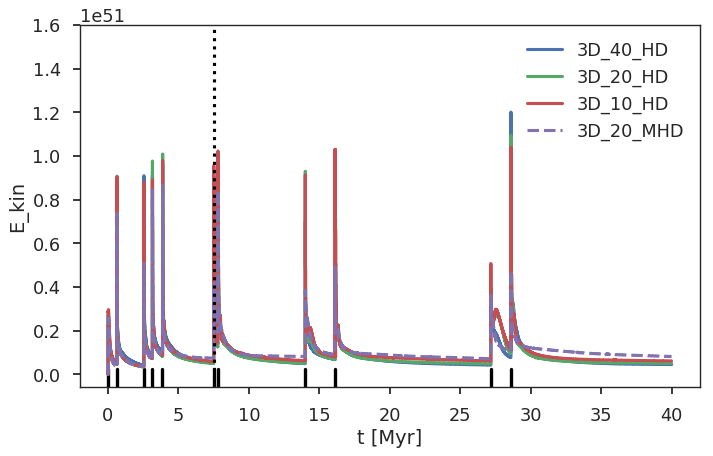

In [11]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_kin = df_energy.E_kin - df_energy.E_kin[0]
    
    linestyle="solid"
    if "mhd" in run_names[i].lower():
        linestyle="dashed"
    
    plt.plot(df_energy.time, E_kin , label=title_map[run_names[i]],
             drawstyle="steps-mid", linestyle=linestyle)
    
plt.xlabel("t [Myr]")
plt.ylabel("E_kin")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
plt.ylim(top=1.6e51)

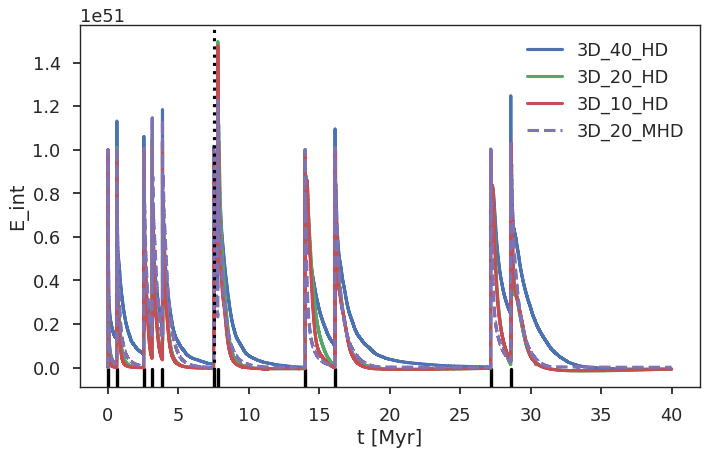

In [12]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_int = df_energy.E_int - df_energy.E_int[0]
    
    linestyle="solid"
    if "mhd" in run_names[i].lower():
        linestyle="dashed"    
    
    plt.plot(df_energy.time, E_int , label=title_map[run_names[i]],
             drawstyle="steps-mid", linestyle=linestyle)
    
plt.xlabel("t [Myr]")
plt.ylabel("E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
# plt.xlim(10,15)

(7.45, 7.6)

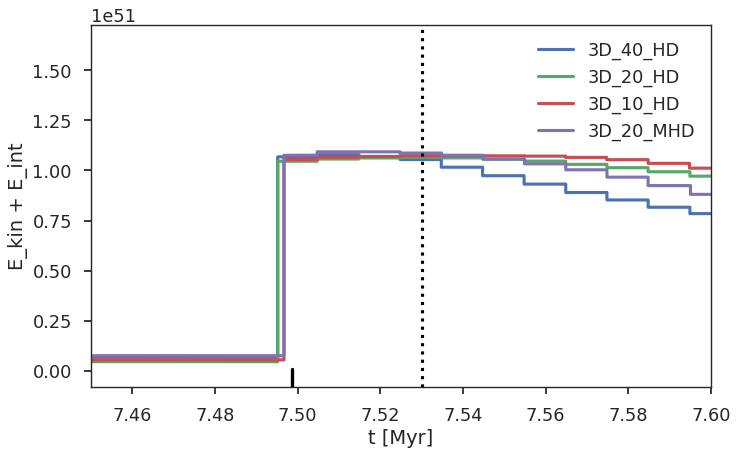

In [13]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]
    
    plt.plot(df_energy.time, E_tot , label=title_map[run_names[i]],
             drawstyle="steps-mid")
    
plt.xlabel("t [Myr]")
plt.ylabel("E_kin + E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
plt.xlim(7.45,7.6)

(7.45, 7.81)

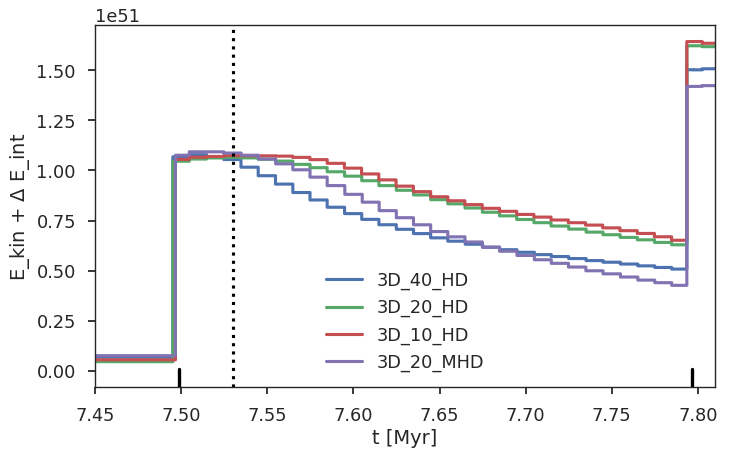

In [14]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]
    
    plt.plot(df_energy.time, E_tot , label=title_map[run_names[i]],
             drawstyle="steps-mid")
    
plt.xlabel("t [Myr]")
plt.ylabel("E_kin + $\Delta$ E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
plt.xlim(7.45, 7.81)

In [17]:
dfs[0].head()

,number,time,e_kin,e_int,e_mag,mass,momentum,run_name
0,0,0.000000,0.000000e+00,4.938177e+50,0.0,7.097382e+06,0.000000e+00,cluster_cooling_100
1,1,0.001000,0.000000e+00,1.493504e+51,0.0,7.097388e+06,0.000000e+00,cluster_cooling_100
2,2,0.127017,1.325320e+50,7.424824e+50,0.0,7.097388e+06,4.048907e+43,cluster_cooling_100
3,3,0.253034,8.578443e+49,6.853737e+50,0.0,7.097388e+06,4.463213e+43,cluster_cooling_100
4,4,0.379051,6.696951e+49,6.545448e+50,0.0,7.097388e+06,4.669316e+43,cluster_cooling_100


In [27]:
dfs[3].e_mag.loc[0]

5.0500481946374368e+52

(7.45, 7.81)

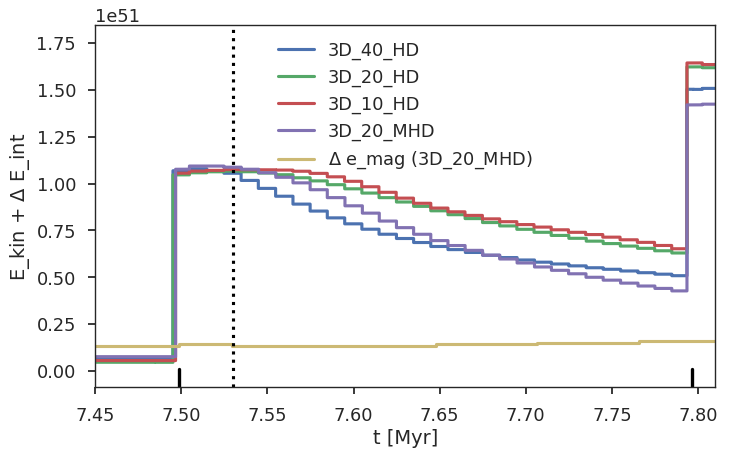

In [33]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]
    
    plt.plot(df_energy.time, E_tot , label=title_map[run_names[i]],
             drawstyle="steps-mid")

df = dfs[-1]
plt.plot(df.time, df.e_mag - df.e_mag.loc[0],
         drawstyle="steps-mid", label = "$\Delta$ e_mag (3D_20_MHD)")
    
plt.xlabel("t [Myr]")
plt.ylabel("E_kin + $\Delta$ E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
plt.xlim(7.45, 7.81)

(27.1, 27.5)

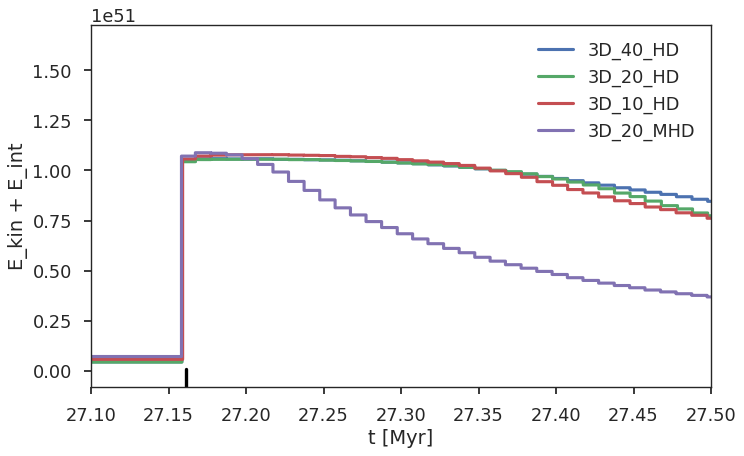

In [15]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]
    
    plt.plot(df_energy.time, E_tot , label=title_map[run_names[i]],
             drawstyle="steps-mid")
    
plt.xlabel("t [Myr]")
plt.ylabel("E_kin + E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
plt.xlim(27.1,27.5)

(25, 30)

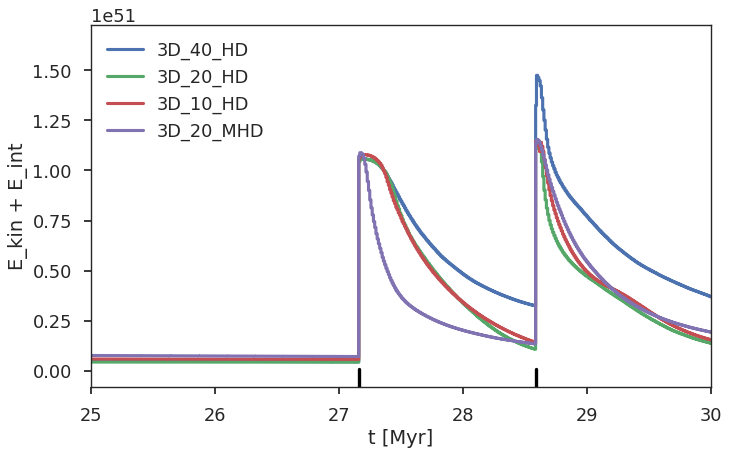

In [16]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]
    
    plt.plot(df_energy.time, E_tot , label=title_map[run_names[i]],
             drawstyle="steps-mid")
    
plt.xlabel("t [Myr]")
plt.ylabel("E_kin + E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
plt.xlim(25,30)

In [46]:
df = dfs[0]

In [47]:
for df in dfs:
    print(df.loc[6][["time", "momentum"]])

time           0.631085
momentum    4.78936e+43
Name: 6, dtype: object
time           0.631085
momentum    4.67581e+43
Name: 6, dtype: object
time           0.631085
momentum    4.86519e+43
Name: 6, dtype: object
time           0.631085
momentum    4.55479e+43
Name: 6, dtype: object


In [48]:
for df in dfs:
    print(df.loc[6].momentum / (100 * M_solar * km / s))

2408.5589848
2351.45393371
2446.69252115
2290.59253384


In [49]:
df_energy = dfs_energy[0]
mask = (df_energy.time > 7.48) & (df_energy.time < 7.53)
df_energy[mask]

,time,E_int,E_kin,E_tot
771,7.481510,4.907291e+50,5.853619e+49,5.492652e+50
772,7.493650,4.907195e+50,5.845140e+49,5.491709e+50
773,7.499704,1.490404e+51,5.842321e+49,1.548827e+51
774,7.499710,1.490375e+51,5.866756e+49,1.549043e+51
775,7.509740,6.038372e+50,9.560494e+50,1.559887e+51
776,7.519710,9.879334e+50,5.758391e+50,1.563773e+51
777,7.529750,1.209619e+51,3.583529e+50,1.567972e+51


In [50]:
df_energy = dfs_energy[1]
mask = (df_energy.time > 7.48) & (df_energy.time < 7.53)
df_energy[mask]

,time,E_int,E_kin,E_tot
756,7.490620,4.905789e+50,4.948583e+49,5.400647e+50
757,7.499704,1.490261e+51,4.944241e+49,1.539703e+51
758,7.499710,1.489750e+51,5.026226e+49,1.540012e+51
759,7.509740,6.700082e+50,8.809469e+50,1.550955e+51
760,7.519710,1.021198e+51,5.351187e+50,1.556316e+51
761,7.529750,1.209302e+51,3.504594e+50,1.559761e+51


In [51]:
df_energy = dfs_energy[-1]
mask = (df_energy.time > 7.48) & (df_energy.time < 7.53)
df_energy[mask]

,time,E_int,E_kin,E_tot
771,7.481510,3.952026e+51,7.473616e+49,4.026762e+51
772,7.493650,3.952026e+51,7.472780e+49,4.026754e+51
773,7.499704,4.951710e+51,7.472494e+49,5.026435e+51
774,7.499710,4.951321e+51,7.564471e+49,5.026966e+51
775,7.509740,4.626321e+51,4.174079e+50,5.043729e+51
776,7.519780,4.685257e+51,3.582806e+50,5.043537e+51
777,7.529750,4.698983e+51,3.385887e+50,5.037572e+51


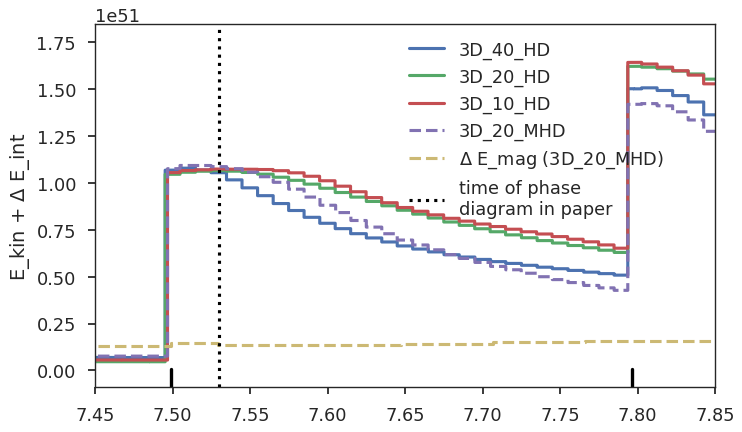

In [89]:
with sns.axes_style("ticks"):

    sns.rugplot(SN_times, color="k", linewidth=3)

    for i, df_energy in enumerate(dfs_energy):
        E_tot = df_energy.E_tot - df_energy.E_tot[0]
        
        linestyle="solid"
        if "mhd" in run_names[i].lower():
            linestyle="dashed"

        plt.plot(df_energy.time, E_tot, label=title_map[run_names[i]],
                 drawstyle="steps-mid", linestyle=linestyle)

    plt.ylabel("E_kin + $\Delta$ E_int")
    
    df = dfs[-1]
    plt.plot(df.time, df.e_mag - df.e_mag.loc[0],
             drawstyle="steps-mid", label = "$\Delta$ E_mag (3D_20_MHD)", linestyle="dashed")

    plt.axvline(7.53, linestyle="dotted", color="black", label="time of phase\ndiagram in paper")
    plt.legend(loc="upper left", bbox_to_anchor=(.48, 1))

    plt.xlim(7.45, 7.85)
    

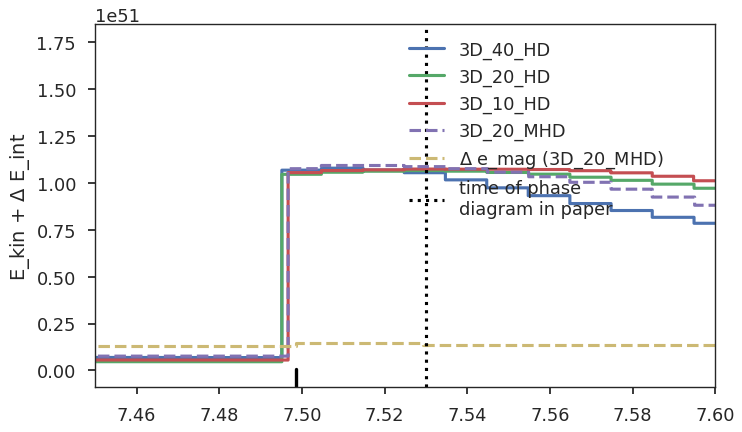

In [86]:
with sns.axes_style("ticks"):

    sns.rugplot(SN_times, color="k", linewidth=3)

    for i, df_energy in enumerate(dfs_energy):
        E_tot = df_energy.E_tot - df_energy.E_tot[0]
        
        linestyle="solid"
        if "mhd" in run_names[i].lower():
            linestyle="dashed"

        plt.plot(df_energy.time, E_tot, label=title_map[run_names[i]],
                 drawstyle="steps-mid", linestyle=linestyle)

    plt.ylabel("E_kin + $\Delta$ E_int")
    
    df = dfs[-1]
    plt.plot(df.time, df.e_mag - df.e_mag.loc[0],
             drawstyle="steps-mid", label = "$\Delta$ e_mag (3D_20_MHD)", linestyle="dashed")

    plt.axvline(7.53, linestyle="dotted", color="black", label="time of phase\ndiagram in paper")
    plt.legend(loc="upper left", bbox_to_anchor=(.48, 1))

    plt.xlim(7.45, 7.6)
    

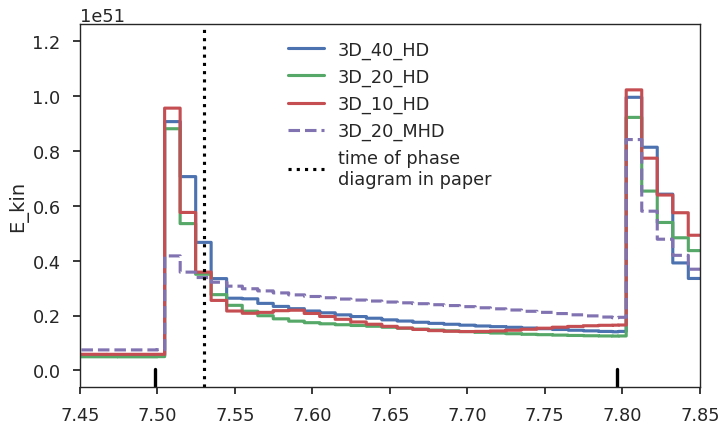

In [87]:
with sns.axes_style("ticks"):

    sns.rugplot(SN_times, color="k", linewidth=3)

    for i, df_energy in enumerate(dfs_energy):
        E_kin = df_energy.E_kin - df_energy.E_kin[0]

        linestyle="solid"
        if "mhd" in run_names[i].lower():
            linestyle="dashed"

        plt.plot(df_energy.time, E_kin, label=title_map[run_names[i]],
                 drawstyle="steps-mid", linestyle=linestyle)

    plt.ylabel("E_kin")

    plt.axvline(7.53, linestyle="dotted", color="black", label="time of phase\ndiagram in paper")
    plt.legend(loc="best")

    plt.xlim(7.45, 7.85)
    

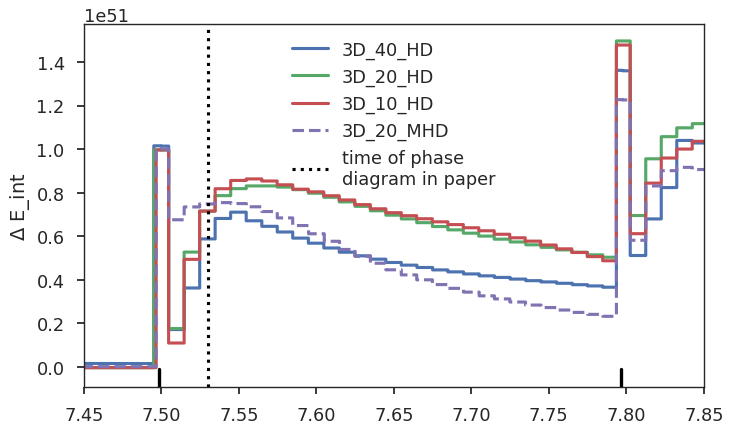

In [88]:
with sns.axes_style("ticks"):

    sns.rugplot(SN_times, color="k", linewidth=3)

    for i, df_energy in enumerate(dfs_energy):
        E_int = df_energy.E_int - df_energy.E_int[0]

        linestyle="solid"
        if "mhd" in run_names[i].lower():
            linestyle="dashed"

        plt.plot(df_energy.time, E_int, label=title_map[run_names[i]],
                 drawstyle="steps-mid", linestyle=linestyle)

    plt.ylabel("$\Delta$ E_int")

    plt.axvline(7.53, linestyle="dotted", color="black", label="time of phase\ndiagram in paper")
    plt.legend(loc="best")

    plt.xlim(7.45, 7.85)
